# HW 3
## Homework 3 for SOCS course 
### Viggo Wessner 

#### **Exercise 1**

In this exercise we have N = 200 active particles (radius R = 1 × 10−6 m) self-propelling with a speed
v = 5 × 10−6 m/s in a fluid with viscosity η = 1 × 10−3 Pa s.
Consider a squared arena with side L = 100 R and periodic boundary conditions.
The particles interact via a phoretic interaction with v0 = 20 × 10−6 m/s. Use a cut-off radius for the interaction
of rc = 10 R. Avoid overlap between the particles with the volume exclusion method.


In [1]:
def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

In [2]:
def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

In [3]:
def remove_overlap(x, y, R, L, dl, N_max_iter):
    """
    Function to remove the overlap between particles.
    Use the volume exclusion methods.
    If N_max_iter iterations are reached, then it stops.
    
    Parameters
    ==========
    x, y : Positions.
    R : Particle radius.
    L : Dimension of the squared arena.
    dl : Tolerance on the overlap. Must be much smaller than R.
    N_max_iter : stops if the number of iterations is larger than this.
    """

    N_part = np.size(x)
    step = 0
    running = True
    
    while running:
        
        n_overlaps = 0
        
        for i in np.arange(N_part):
            for j in np.arange(i + 1, N_part):                
                # Check overlap.
                dx = x[j] - x[i]
                dy = y[j] - y[i]
                dist = np.sqrt(dx ** 2 + dy ** 2)
                
                if dist < 2 * R - dl:
                    n_overlaps += 1  # Increment overlap counter.
                    # Remove overlap.
                    xm = 0.5 * (x[j] + x[i]) 
                    ym = 0.5 * (y[j] + y[i]) 
                    x[i] = xm - dx / dist * R
                    y[i] = ym - dy / dist * R
                    x[j] = xm + dx / dist * R
                    y[j] = ym + dy / dist * R
                
        step += 1
        
        if (step >= N_max_iter) or (n_overlaps == 0):
            running = False
    
    x, y = pbc(x, y, L)  # Apply periodic boundary conditions.

    return x, y     


In [4]:
from functools import reduce

def phoretic_velocity(x, y, R, v0, r_c, L):
    """
    Function to calculate the phoretic velocity.
    
    Parameters
    ==========
    x, y : Positions.
    R : Particle radius.
    v0 : Phoretic reference velocity.
    r_c : Cut-off radius.
    L : Dimension of the squared arena.
    """
    
    N = np.size(x)

    vx = np.zeros(N)  # Phoretic velocity (x component).
    vy = np.zeros(N)  # Phoretic velocity (y component).
    
    # Preselect what particles are closer than r_c to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + r_c > L / 2)[0], 
            np.where(y - r_c < - L / 2)[0],
            np.where(x + r_c > L / 2)[0],
            np.where(x - r_c > - L / 2)[0]
        )
    )

    for j in range(N - 1):   
        
        # Check if replicas are needed to find the interacting neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            for nr in range(9):
                dist2 = (x[j + 1:] - xr[nr]) ** 2 + (y[j + 1:] - yr[nr]) ** 2 
                nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
                
                # The list of nearest neighbours is set.
                # Contains only the particles with index > j
        
                if np.size(nn) > 0:
                    nn = nn.astype(int)
        
                    # Find interaction
                    dx = x[nn] - xr[nr]
                    dy = y[nn] - yr[nr]
                    dist = np.sqrt(dx ** 2 + dy ** 2)
                    v_p = v0 * R ** 2 / dist ** 2
                    dvx = dx / dist * v_p
                    dvy = dy / dist * v_p
            
                    # Contribution for particle j.
                    vx[j] += np.sum(dvx)
                    vy[j] += np.sum(dvy)

                    # Contribution for nn of particle j nr replica.
                    vx[nn] -= dvx
                    vy[nn] -= dvy
                
        else:
            dist2 = (x[j + 1:] - x[j]) ** 2 + (y[j + 1:] - y[j]) ** 2 
            nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
        
            # The list of nearest neighbours is set.
            # Contains only the particles with index > j
        
            if np.size(nn) > 0:
                nn = nn.astype(int)
        
                # Find interaction
                dx = x[nn] - x[j]
                dy = y[nn] - y[j]
                dist = np.sqrt(dx ** 2 + dy ** 2)
                v_p = v0 * R ** 2 / dist ** 2
                dvx = dx / dist * v_p
                dvy = dy / dist * v_p
            
                # Contribution for particle j.
                vx[j] += np.sum(dvx)
                vy[j] += np.sum(dvy)

                # Contribution for nn of particle j.
                vx[nn] -= dvx
                vy[nn] -= dvy
                   
    return vx, vy


#### **Q1** - Decide the time step ∆t for your simulation. When you choose it, what elements you have to consider? Does the value of the speed v, the radius R, or other parameters play a role in your decision? Write down your ∆t.

The displacement of a particle in one time step $v\Delta t$ should not exceed the cut-off radius $r_c$. For safeness $v\Delta t < r_c$.
Since interaction is characterized by $v_0$ make sure $v_0 \Delta t < r_c$
Displacement in one step should not exceed a fraction of $R$ so that particles dont overlap $v_0 \Delta t < R$.

Which gives $\Delta t < 2, \Delta t < 0.5, \Delta t < 0.05$. So pick $\Delta t = 0.01$

#### **P1** Initialize the position of the particles at random. Set their initial direction at random. Plot the configuration at t = 0 s, 5 s, 10 s, 20 s, 50 s. You have to indicate the orientation of each particle in the plot.

In [7]:
import numpy as np

N_part = 200  # Number of active Brownian particles.

R = 1e-6  # Radius of the Brownian particle [m].
eta = 1e-3  # Viscosity of the medium.
gamma = 6 * np.pi * R * eta  # Drag coefficient. 
gammaR = 8 * np.pi * R ** 3 * eta  # Rotational drag coefficient. 
kBT = 4.11e-21  # kB*T at room temperature [J].
D = kBT / gamma  # Diffusion constant [m^2 / s].
DR = kBT / gammaR  # Rotational diffusion constant [1 / s].
t_r = 1 / DR  # Orientation relaxation time.
dt = 0.01  # Time step [s].
duration = 51 # [s]

v = 5e-6  # Self-propulsion speed [m/s].

v0 = 20e-6  # Phoretic reference speed [m/s].
r_c = 10 * R  # Cut-off radius [m].

L = 100 * R  # Side of the arena.

print(f't_r={t_r:.3f} s')

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_x = np.sqrt(2 * D * dt)
c_noise_y = np.sqrt(2 * D * dt)
c_noise_phi = np.sqrt(2 * DR * dt)



t_r=6.115 s


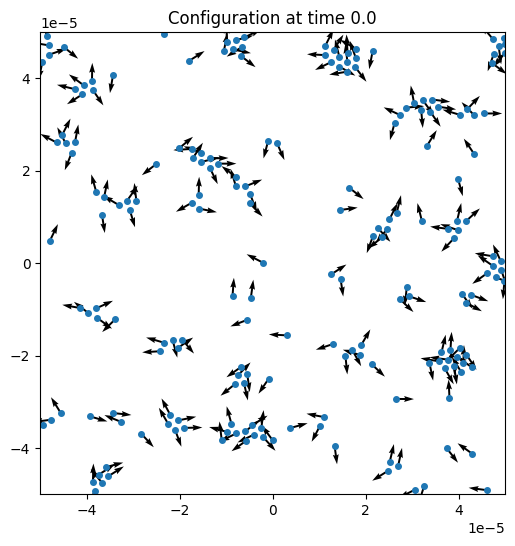

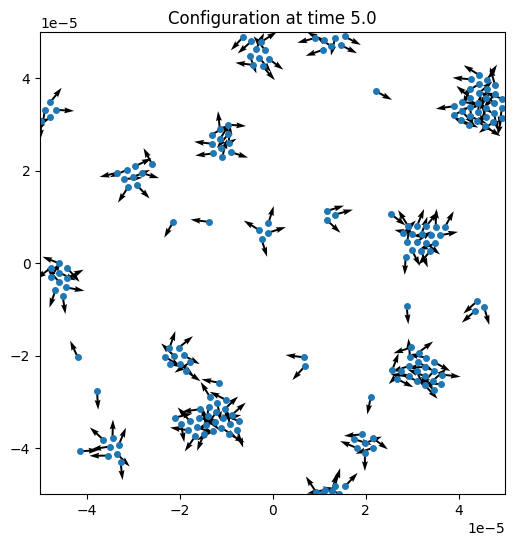

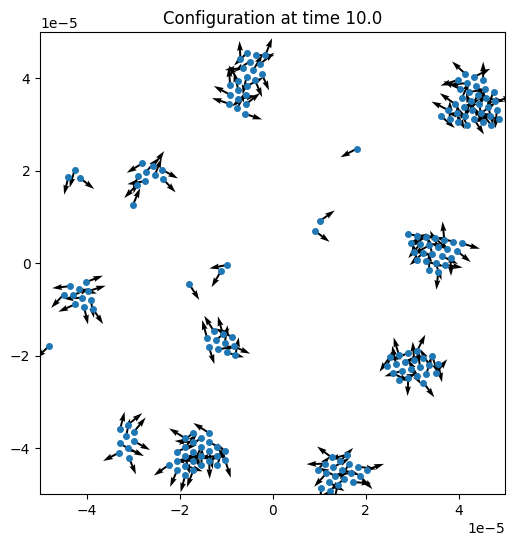

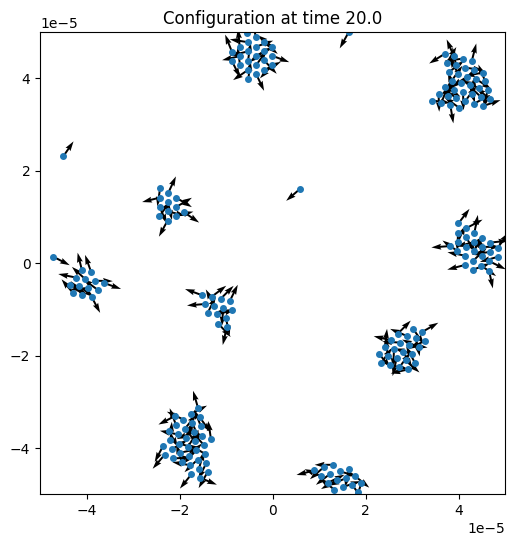

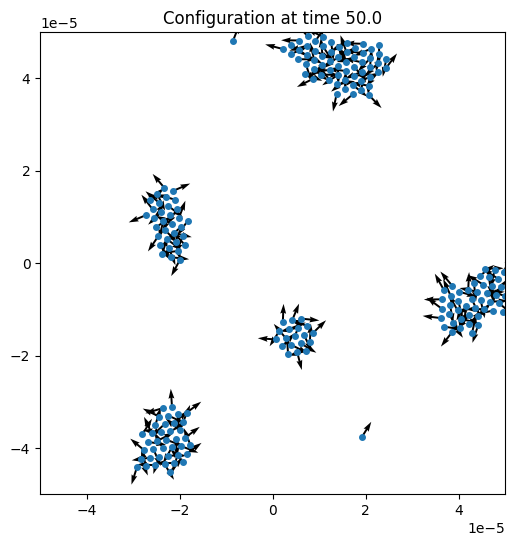

In [11]:
import matplotlib.pyplot as plt

time_checks = [0.0, 5.0, 10.0 , 20.0, 50.0]


for t in np.arange(0,51, dt):

    

    # Calculate phoretic velocity.
    vp_x, vp_y = phoretic_velocity(x, y, R, v0, r_c, L)
       
    # Calculate new positions and orientations.
    nx = x + (v * np.cos(phi) + vp_x) * dt + c_noise_x * np.random.normal(0, 1, N_part)
    ny = y + (v * np.sin(phi) + vp_y) * dt + c_noise_y * np.random.normal(0, 1, N_part)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)

    # Apply pbc.
    nx, ny = pbc(nx, ny, L)
    
    # Remove overlap.
    nx, ny = remove_overlap(nx, ny, R, L, dl=1e-8, N_max_iter=20)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    if t in time_checks:
        plt.figure(figsize=(6, 6))
        plt.plot(x, y, '.', markersize=8 )
        plt.quiver(x, y, np.cos(phi), np.sin(phi))
        plt.title(f'Configuration at time {t}')
        plt.xlim([- L / 2, L / 2])
        plt.ylim([- L / 2, L / 2])
        plt.show()



    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]  



#### **Q2** - Describe the behavior of the  system in **P1**. 
The particles cluster quickly and stay clustered. Not very aligned.

#### **P2** - Now set $L = 50 R$ and re-run the simulation. initialize the position of the particles at random. Set their initial direction at random. Pot the configuratoin at $t= 0, 5 ,10, 20 ,50$

In [13]:
import numpy as np

N_part = 200  # Number of active Brownian particles.

R = 1e-6  # Radius of the Brownian particle [m].
eta = 1e-3  # Viscosity of the medium.
gamma = 6 * np.pi * R * eta  # Drag coefficient. 
gammaR = 8 * np.pi * R ** 3 * eta  # Rotational drag coefficient. 
kBT = 4.11e-21  # kB*T at room temperature [J].
D = kBT / gamma  # Diffusion constant [m^2 / s].
DR = kBT / gammaR  # Rotational diffusion constant [1 / s].
t_r = 1 / DR  # Orientation relaxation time.
dt = 0.01  # Time step [s].
duration = 51 # [s]

v = 5e-6  # Self-propulsion speed [m/s].

v0 = 20e-6  # Phoretic reference speed [m/s].
r_c = 10 * R  # Cut-off radius [m].

L = 50 * R  # Side of the arena.

print(f't_r={t_r:.3f} s')

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_x = np.sqrt(2 * D * dt)
c_noise_y = np.sqrt(2 * D * dt)
c_noise_phi = np.sqrt(2 * DR * dt)

t_r=6.115 s


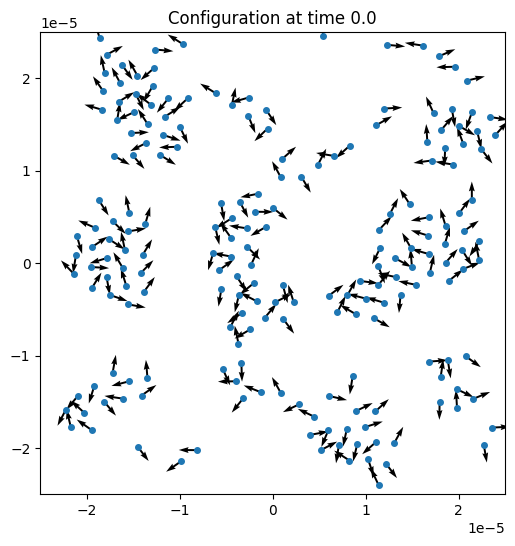

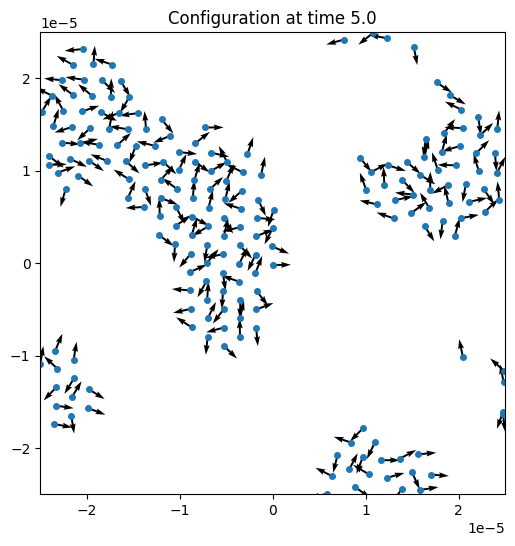

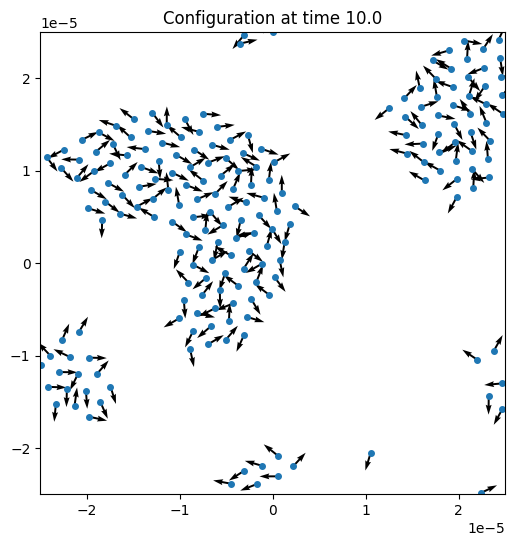

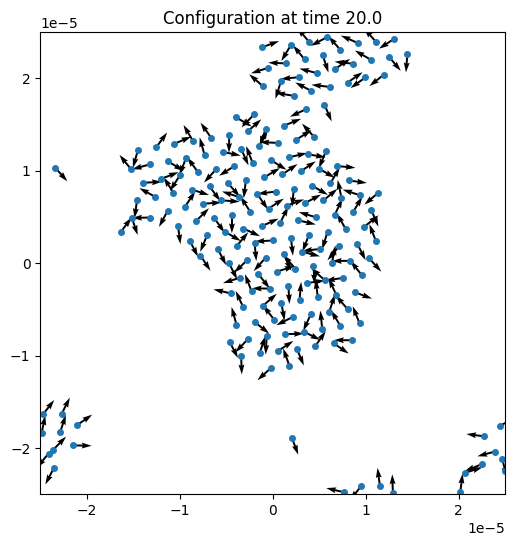

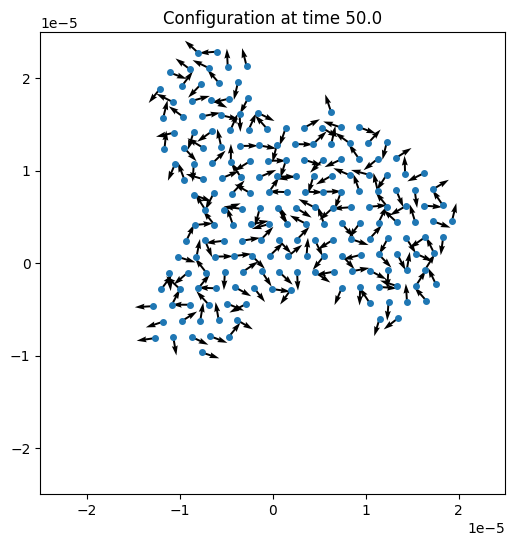

In [15]:
import matplotlib.pyplot as plt
dt = 4e-2

time_checks = [0.0, 5.0, 10.0 , 20.0, 50.0]


for t in np.arange(0,51, dt):

    

    # Calculate phoretic velocity.
    vp_x, vp_y = phoretic_velocity(x, y, R, v0, r_c, L)
       
    # Calculate new positions and orientations.
    nx = x + (v * np.cos(phi) + vp_x) * dt + c_noise_x * np.random.normal(0, 1, N_part)
    ny = y + (v * np.sin(phi) + vp_y) * dt + c_noise_y * np.random.normal(0, 1, N_part)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)

    # Apply pbc.
    nx, ny = pbc(nx, ny, L)
    
    # Remove overlap.
    nx, ny = remove_overlap(nx, ny, R, L, dl=1e-8, N_max_iter=20)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    if t in time_checks:
        plt.figure(figsize=(6, 6))
        plt.plot(x, y, '.', markersize=8 )
        plt.quiver(x, y, np.cos(phi), np.sin(phi))
        plt.title(f'Configuration at time {t}')
        plt.xlim([- L / 2, L / 2])
        plt.ylim([- L / 2, L / 2])
        plt.show()



    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]  

#### **Q2** - Describe the behavior of the system in **P2**. Compare it with the system in **P1**. 
The particles quickly gather into one large cluster, this is different from the previous plots where there were multiple clusters of lagom size.

### **EXERCISE 2**

#### **P1**

In [44]:
import numpy as np
from scipy.spatial import distance
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def find_clusters(x, y, r0):
    """
    Find clusters of particles based on a cut-off radius r0.

    Parameters:
        x (array-like): x-coordinates of particles.
        y (array-like): y-coordinates of particles.
        r0 (float): Cut-off radius for clustering.

    Returns:
        clusters (list of lists): Each sublist contains indices of particles in the same cluster.
    """
    # Combine x and y into positions
    positions = np.column_stack((x, y))

    num_particles = len(x)

    # Compute the pairwise distances between all particles
    dist_matrix = distance.cdist(positions, positions, 'euclidean')

    # Create an adjacency matrix based on the cut-off radius
    adjacency_matrix = dist_matrix < r0

    # Remove self-loops
    np.fill_diagonal(adjacency_matrix, False)

    # Convert the adjacency matrix to a CSR (Compressed Sparse Row) format
    graph = csr_matrix(adjacency_matrix)

    # Use scipy's connected_components to find clusters
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

    # Group particle indices by their component labels
    clusters = [[] for _ in range(n_components)]
    for idx, label in enumerate(labels):
        clusters[label].append(idx)

    return clusters

In [16]:
def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

In [17]:
def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

In [18]:
from functools import reduce

def calculate_intensity(x, y, I0, r0, L, r_c):
    """
    Function to calculate the intensity seen by each particle.
    
    Parameters
    ==========
    x, y : Positions.
    r0 : Standard deviation of the Gaussian light intensity zone.
    I0 : Maximum intensity of the Gaussian.
    L : Dimension of the squared arena.
    r_c : Cut-off radius. Pre-set it around 3 * r0. 
    """
    
    N = np.size(x)

    I_particle = np.zeros(N)  # Intensity seen by each particle.
    
    # Preselect what particles are closer than r_c to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + r_c > L / 2)[0], 
            np.where(y - r_c < - L / 2)[0],
            np.where(x + r_c > L / 2)[0],
            np.where(x - r_c > - L / 2)[0]
        )
    )

    for j in range(N - 1):   
        
        # Check if replicas are needed to find the interacting neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            for nr in range(9):
                dist2 = (x[j + 1:] - xr[nr]) ** 2 + (y[j + 1:] - yr[nr]) ** 2 
                nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
                
                # The list of nearest neighbours is set.
                # Contains only the particles with index > j
        
                if np.size(nn) > 0:
                    nn = nn.astype(int)
        
                    # Find total intensity
                    dx = x[nn] - xr[nr]
                    dy = y[nn] - yr[nr]
                    d2 = dx ** 2 + dy ** 2
                    I = I0 * np.exp(- d2 / r0 ** 2)
                    
                    # Contribution for particle j.
                    I_particle[j] += np.sum(I)

                    # Contribution for nn of particle j nr replica.
                    I_particle[nn] += I
                
        else:
            dist2 = (x[j + 1:] - x[j]) ** 2 + (y[j + 1:] - y[j]) ** 2 
            nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
        
            # The list of nearest neighbours is set.
            # Contains only the particles with index > j
        
            if np.size(nn) > 0:
                nn = nn.astype(int)
        
                # Find interaction
                dx = x[nn] - x[j]
                dy = y[nn] - y[j]
                d2 = dx ** 2 + dy ** 2
                I = I0 * np.exp(- d2 / r0 ** 2)
                
                # Contribution for particle j.
                I_particle[j] += np.sum(I)

                # Contribution for nn of particle j.
                I_particle[nn] += I
                   
    return I_particle


In [45]:
import numpy as np

N_part = 50  # Number of light-sensitive robots. 
# Note: 5 is enough to demonstrate clustering - dispersal. 

tau = 1  # Timescale of the orientation diffusion.
dt = 0.05  # Time step [s].

v0 = 0.1  # Self-propulsion speed at I=0 [m/s].
v_inf = 0.01  # Self-propulsion speed at I=+infty [m/s].
Ic = 0.1  # Intensity scale where the speed decays.
I0 = 1  # Maximum intensity.
r0 = 0.3  # Standard deviation of the Gaussian light intensity zone [m].

# delta = 0  # No delay. Tends to cluster.
delta = 5 * tau  # Positive delay. More stable clustering.
# delta = - 5 * tau  # Negative delay. Dispersal.

r_c = 4 * r0  # Cut-off radius [m].
L = 30 * r0  # Side of the arena[m].

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_phi = np.sqrt(2 * dt / tau)


if delta < 0:
    # Negative delay.
    n_fit = 5 
    I_fit = np.zeros([n_fit, N_part])
    t_fit = np.arange(n_fit) * dt
    dI_dt = np.zeros(N_part)
    # Initialize.
    I_ref = I0 * np.exp(- (x ** 2 + y ** 2) / r0 ** 2)
    for i in range(n_fit):
        I_fit[i, :] += I_ref   
        
if delta > 0:
    # Positive delay.
    n_fit = 5
    n_delay = int(delta / dt)  # Delay in units of time steps.
    I_memory = np.zeros([n_delay, N_part])
    # Initialize.
    I_ref = I0 * np.exp(- (x ** 2 + y ** 2) / r0 ** 2)
    for i in range(n_fit):
        I_memory[i, :] += I_ref   
        
    

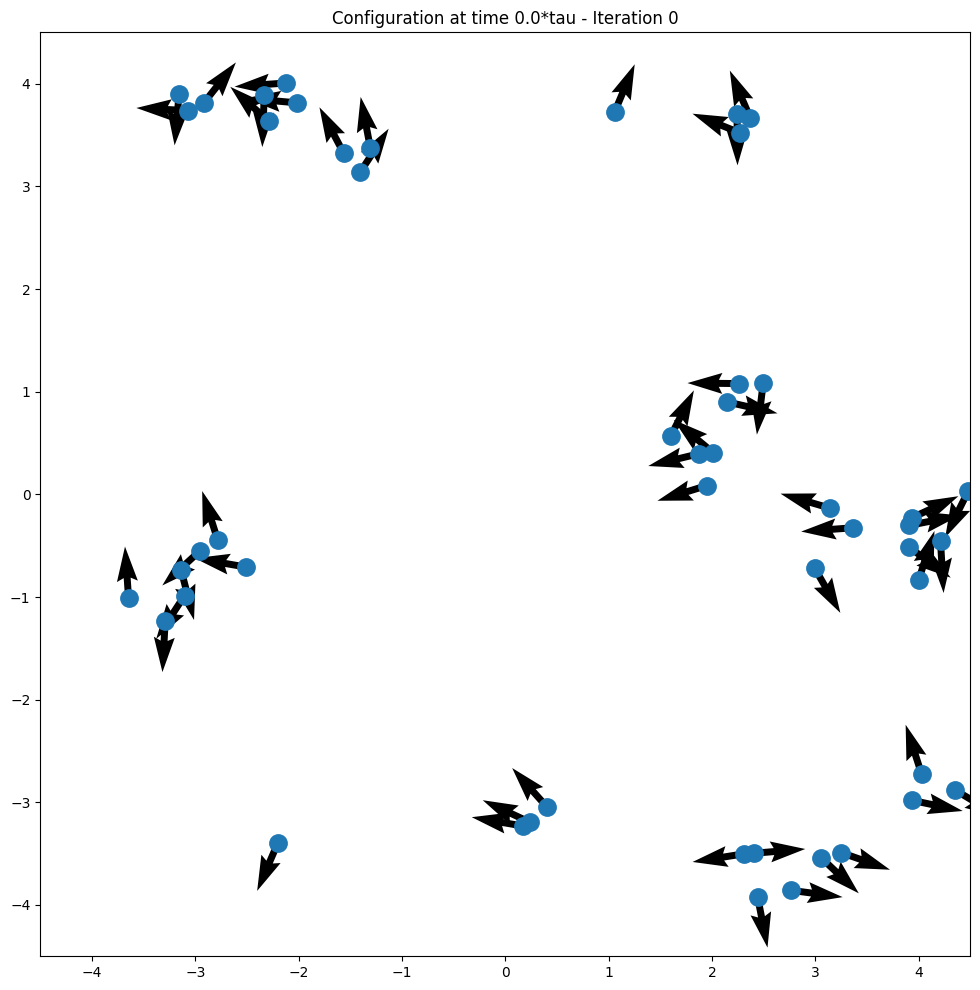

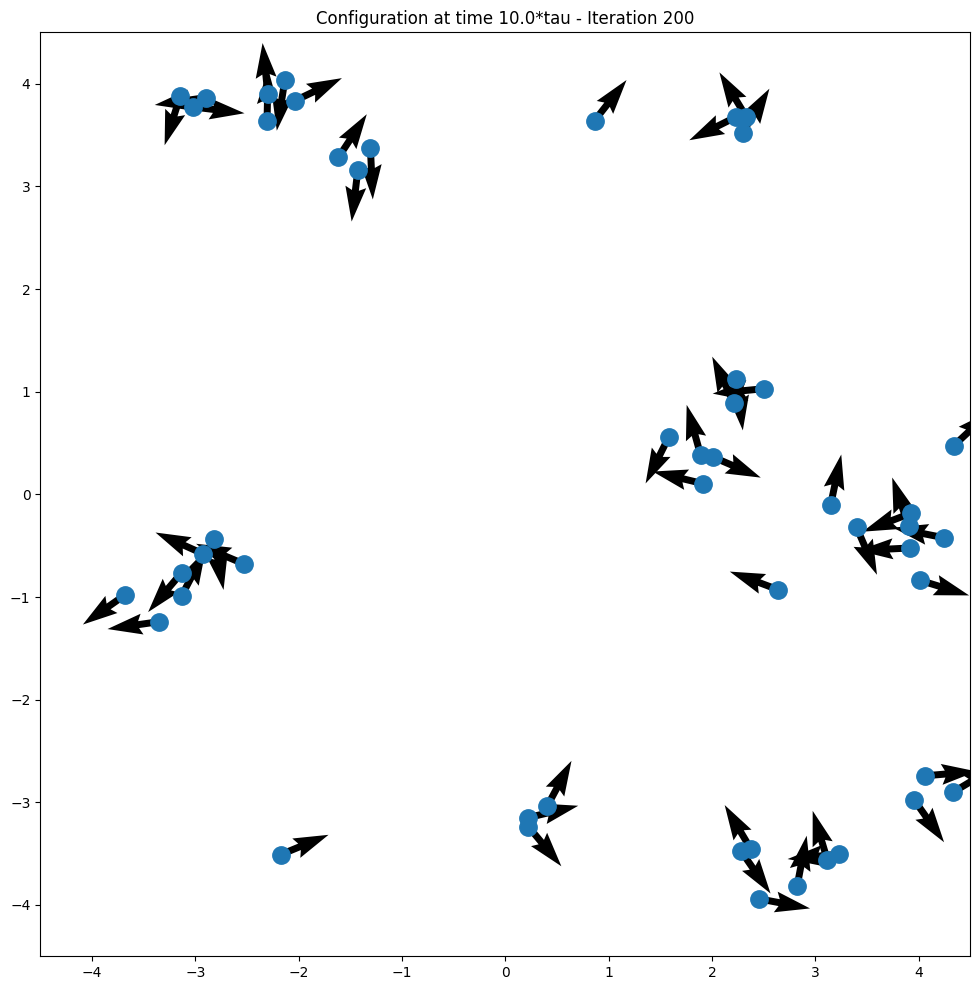

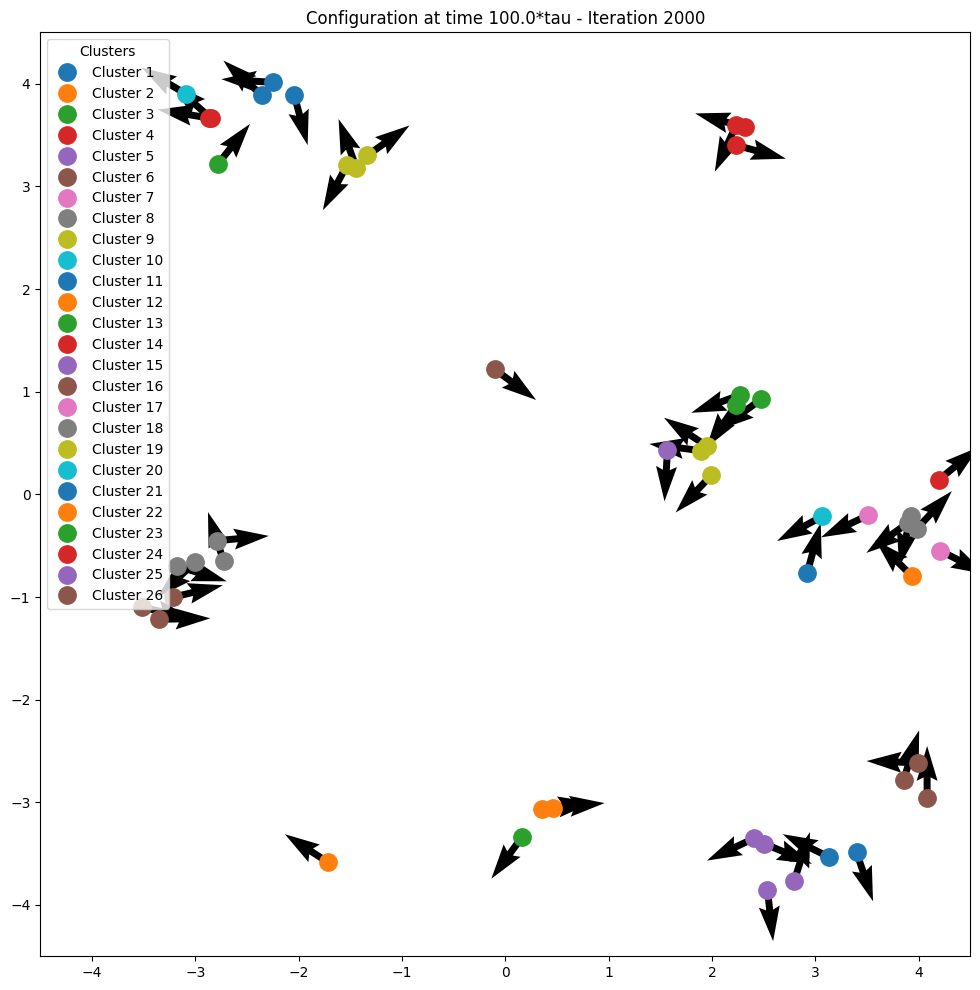

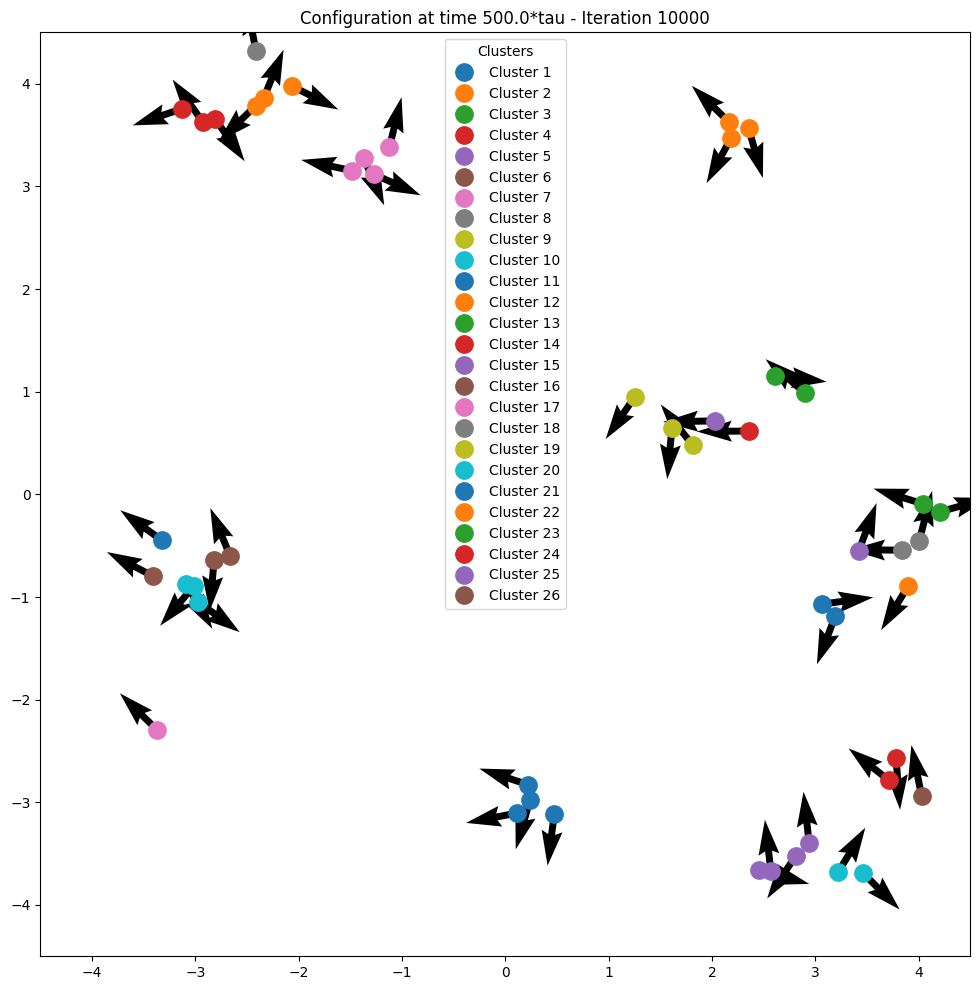

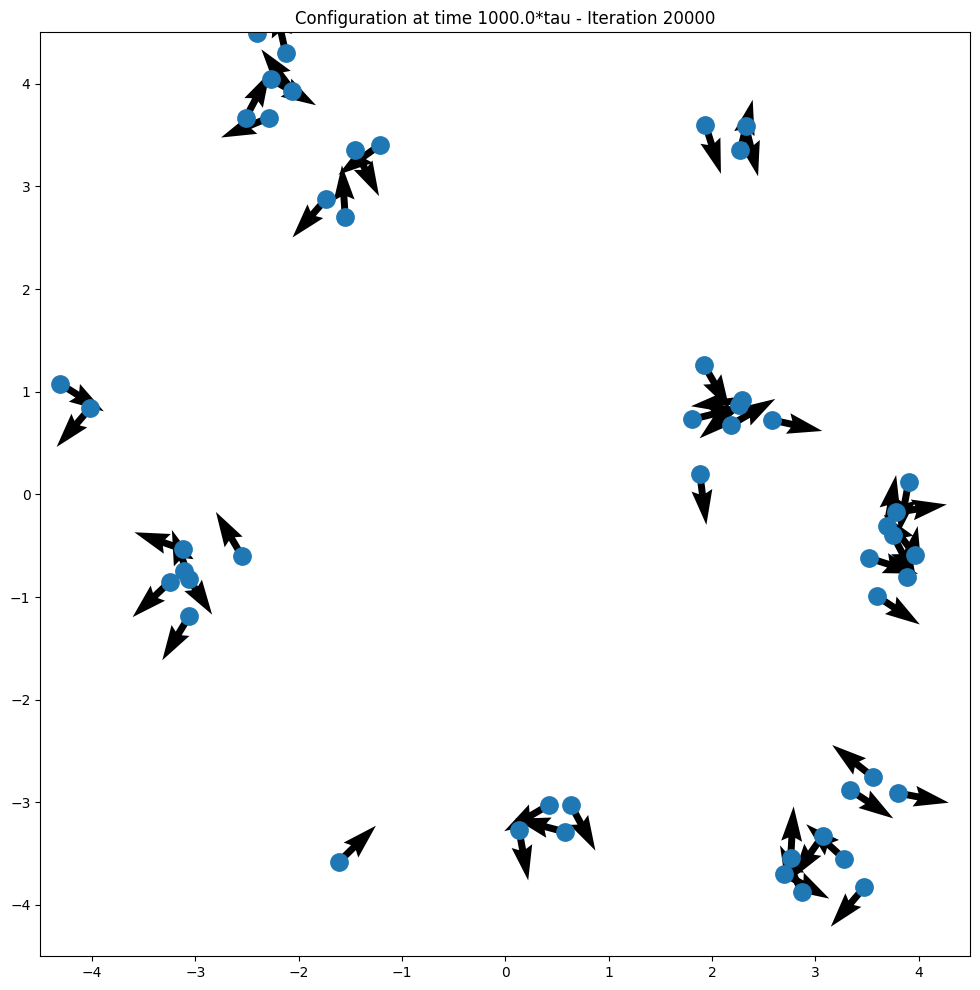

In [50]:
import math

time_checks = [0, 10, 100, 500, 1000]
duration = 1001*tau

steps = math.ceil(duration/dt)



for step in range(steps):
    # Calculate current I.
    I_particles = calculate_intensity(x, y, I0, r0, L, r_c)
    
    if delta < 0:
        # Estimate the derivative of I linear using the last n_fit values.
        for i in range(N_part - 1):
            # Update I_fit.
            I_fit = np.roll(I_fit, -1, axis=0)
            I_fit[-1, :] = I_particles
            # Fit to determine the slope.
            for j in range(N_part):
                p = np.polyfit(t_fit, I_fit[:, j], 1)
                dI_dt[j] = p[0]
            # Determine forecast. Remember that here delta is negative.
            I = I_particles - delta * dI_dt  
            I[np.where(I < 0)[0]] = 0
    elif delta > 0:
        # Update I_memory.
        I_memory = np.roll(I_memory, -1, axis=0)
        I_memory[-1, :] = I_particles    
        I = I_memory[0, :]
    else:
        I = I_particles
       
    # Calculate new positions and orientations. 
    v = v_inf + (v0 - v_inf) * np.exp(- I / Ic) 
    nx = x + v * dt * np.cos(phi)
    ny = y + v * dt * np.sin(phi)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)


    # Apply pbc.
    nx, ny = pbc(nx, ny, L)

    if step*dt in time_checks:
        if step*dt == 100*tau or step*dt == 500*tau:
            clusters = find_clusters(x,y,r0)
            plt.figure(figsize=(12, 12))
            colors = plt.cm.tab10.colors
            for i, cluster in enumerate(clusters):
                cluster_x = x[cluster]
                cluster_y = y[cluster]
                plt.plot(cluster_x, cluster_y, '.', markersize = 25, label=f'Cluster {i+1}')
    
            plt.quiver(x, y, np.cos(phi), np.sin(phi))
            plt.title(f'Configuration at time {step*dt}*tau - Iteration {step}')
            legend = plt.legend(title="Clusters", frameon=True)
            legend.set_alpha(0.7)  # Make the legend more opaque
            plt.xlim([- L / 2, L / 2])
            plt.ylim([- L / 2, L / 2])
            plt.show()
        else:
            plt.figure(figsize=(12, 12))
            plt.plot(x, y, '.', markersize=25 )
            plt.quiver(x, y, np.cos(phi), np.sin(phi))
            plt.title(f'Configuration at time {step*dt}*tau - Iteration {step}')
            plt.xlim([- L / 2, L / 2])
            plt.ylim([- L / 2, L / 2])
            plt.show()

    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]

### **P2** Repeat with negative delay

In [51]:
import numpy as np

N_part = 50  # Number of light-sensitive robots. 
# Note: 5 is enough to demonstrate clustering - dispersal. 

tau = 1  # Timescale of the orientation diffusion.
dt = 0.05  # Time step [s].

v0 = 0.1  # Self-propulsion speed at I=0 [m/s].
v_inf = 0.01  # Self-propulsion speed at I=+infty [m/s].
Ic = 0.1  # Intensity scale where the speed decays.
I0 = 1  # Maximum intensity.
r0 = 0.3  # Standard deviation of the Gaussian light intensity zone [m].

# delta = 0  # No delay. Tends to cluster.
#delta = 5 * tau  # Positive delay. More stable clustering.
delta = - 5 * tau  # Negative delay. Dispersal.

r_c = 4 * r0  # Cut-off radius [m].
L = 30 * r0  # Side of the arena[m].

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_phi = np.sqrt(2 * dt / tau)


if delta < 0:
    # Negative delay.
    n_fit = 5 
    I_fit = np.zeros([n_fit, N_part])
    t_fit = np.arange(n_fit) * dt
    dI_dt = np.zeros(N_part)
    # Initialize.
    I_ref = I0 * np.exp(- (x ** 2 + y ** 2) / r0 ** 2)
    for i in range(n_fit):
        I_fit[i, :] += I_ref   
        
if delta > 0:
    # Positive delay.
    n_fit = 5
    n_delay = int(delta / dt)  # Delay in units of time steps.
    I_memory = np.zeros([n_delay, N_part])
    # Initialize.
    I_ref = I0 * np.exp(- (x ** 2 + y ** 2) / r0 ** 2)
    for i in range(n_fit):
        I_memory[i, :] += I_ref   
        
    

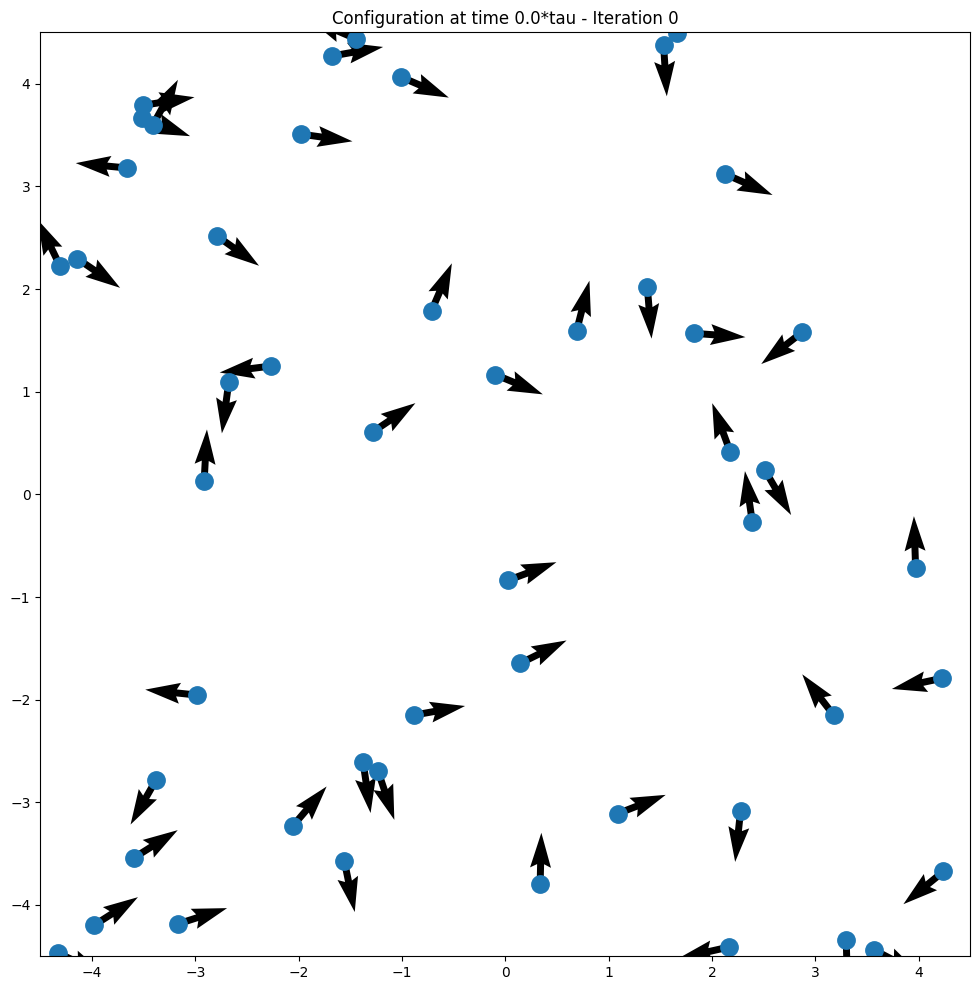

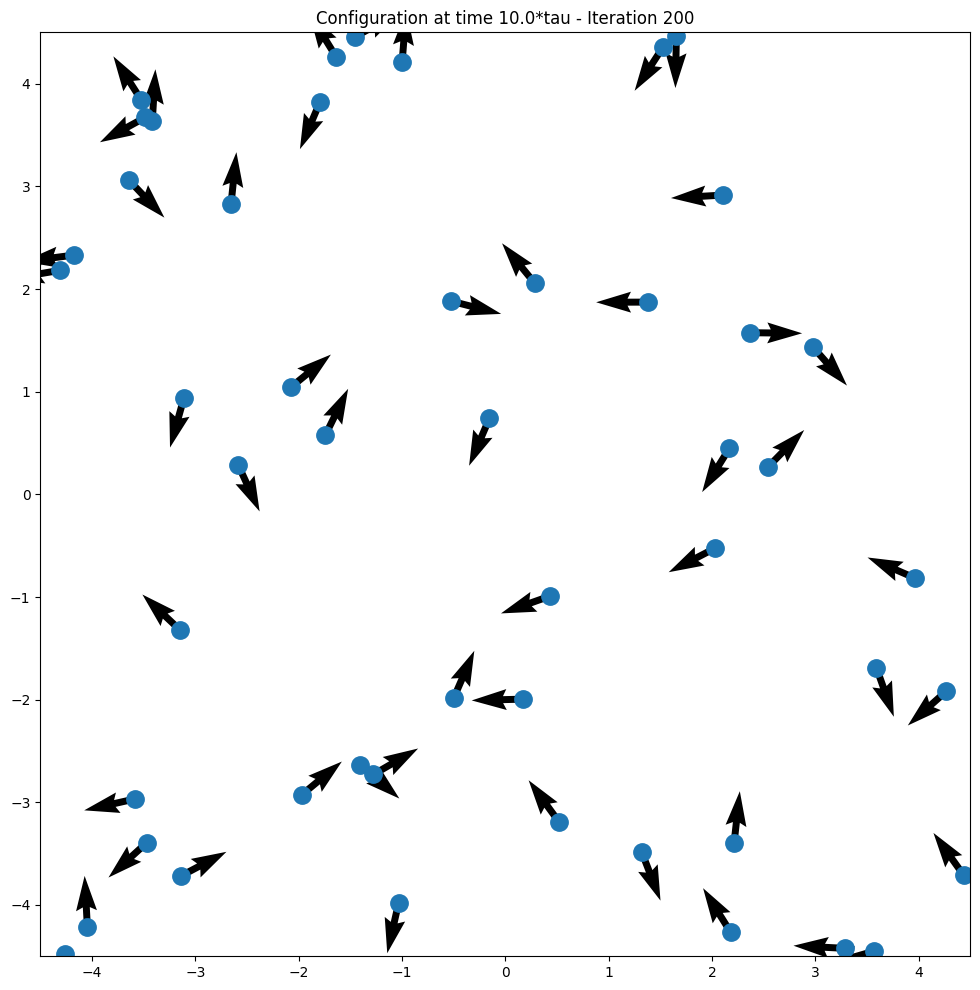

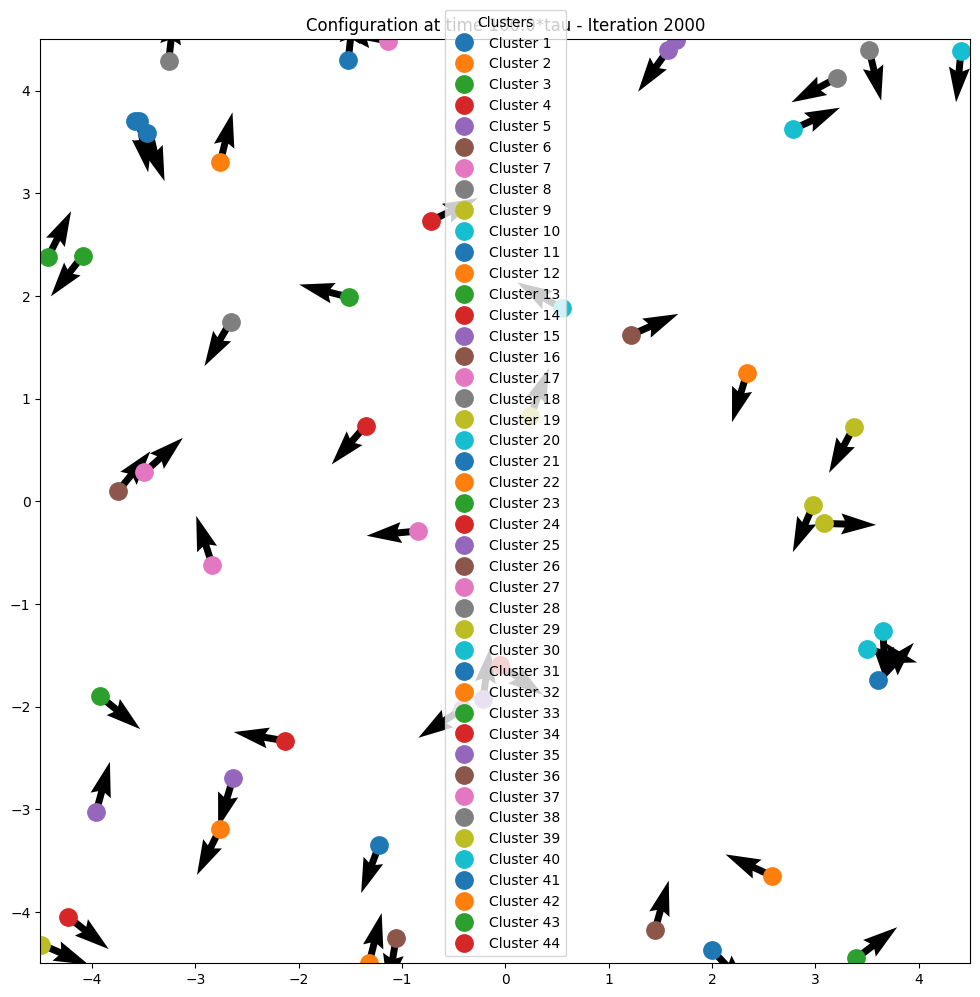

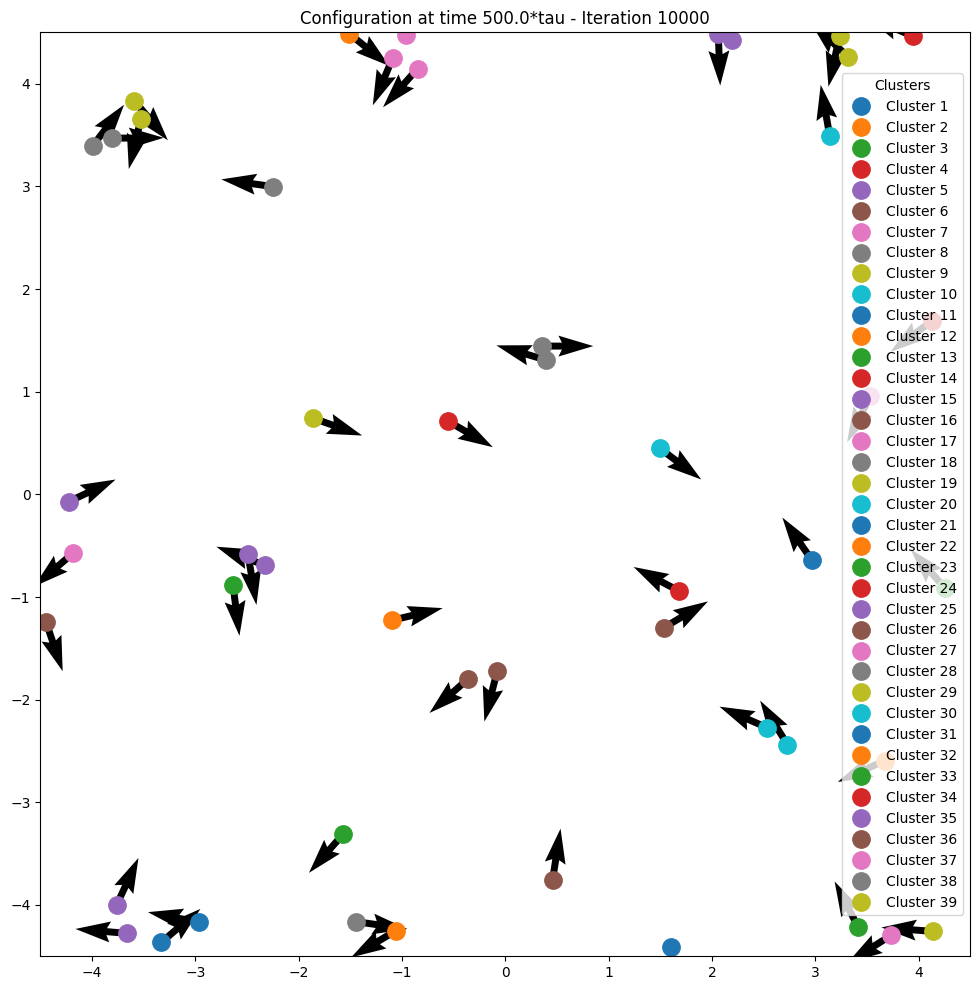

In [52]:
import math

time_checks = [0, 10, 100, 500]
duration = 1001*tau

steps = math.ceil(duration/dt)



for step in range(steps):
    # Calculate current I.
    I_particles = calculate_intensity(x, y, I0, r0, L, r_c)
    
    if delta < 0:
        # Estimate the derivative of I linear using the last n_fit values.
        for i in range(N_part - 1):
            # Update I_fit.
            I_fit = np.roll(I_fit, -1, axis=0)
            I_fit[-1, :] = I_particles
            # Fit to determine the slope.
            for j in range(N_part):
                p = np.polyfit(t_fit, I_fit[:, j], 1)
                dI_dt[j] = p[0]
            # Determine forecast. Remember that here delta is negative.
            I = I_particles - delta * dI_dt  
            I[np.where(I < 0)[0]] = 0
    elif delta > 0:
        # Update I_memory.
        I_memory = np.roll(I_memory, -1, axis=0)
        I_memory[-1, :] = I_particles    
        I = I_memory[0, :]
    else:
        I = I_particles
       
    # Calculate new positions and orientations. 
    v = v_inf + (v0 - v_inf) * np.exp(- I / Ic) 
    nx = x + v * dt * np.cos(phi)
    ny = y + v * dt * np.sin(phi)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)


    # Apply pbc.
    nx, ny = pbc(nx, ny, L)

    if step*dt in time_checks:
        if step*dt == 100*tau or step*dt == 500*tau:
            clusters = find_clusters(x,y,r0)
            plt.figure(figsize=(12, 12))
            colors = plt.cm.tab10.colors
            for i, cluster in enumerate(clusters):
                cluster_x = x[cluster]
                cluster_y = y[cluster]
                plt.plot(cluster_x, cluster_y, '.', markersize = 25, label=f'Cluster {i+1}')
    
            plt.quiver(x, y, np.cos(phi), np.sin(phi))
            plt.title(f'Configuration at time {step*dt}*tau - Iteration {step}')
            legend = plt.legend(title="Clusters", frameon=True)
            legend.set_alpha(0.7)  # Make the legend more opaque
            plt.xlim([- L / 2, L / 2])
            plt.ylim([- L / 2, L / 2])
            plt.show()
        else:
            plt.figure(figsize=(12, 12))
            plt.plot(x, y, '.', markersize=25 )
            plt.quiver(x, y, np.cos(phi), np.sin(phi))
            plt.title(f'Configuration at time {step*dt}*tau - Iteration {step}')
            plt.xlim([- L / 2, L / 2])
            plt.ylim([- L / 2, L / 2])
            plt.show()

    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]

In [ ]:
import numpy as np
from scipy.spatial import distance
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def find_clusters(x, y, r0):
    """
    Find clusters of particles based on a cut-off radius r0.

    Parameters:
        x (array-like): x-coordinates of particles.
        y (array-like): y-coordinates of particles.
        r0 (float): Cut-off radius for clustering.

    Returns:
        clusters (list of lists): Each sublist contains indices of particles in the same cluster.
    """
    # Combine x and y into positions
    positions = np.column_stack((x, y))

    num_particles = len(x)

    # Compute the pairwise distances between all particles
    dist_matrix = distance.cdist(positions, positions, 'euclidean')

    # Create an adjacency matrix based on the cut-off radius
    adjacency_matrix = dist_matrix < r0

    # Remove self-loops
    np.fill_diagonal(adjacency_matrix, False)

    # Convert the adjacency matrix to a CSR (Compressed Sparse Row) format
    graph = csr_matrix(adjacency_matrix)

    # Use scipy's connected_components to find clusters
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

    # Group particle indices by their component labels
    clusters = [[] for _ in range(n_components)]
    for idx, label in enumerate(labels):
        clusters[label].append(idx)

    return clusters

#### **Q1** - Do you notice any difference for the two clustering in **P3**? Comment.

It seems the system with positive delay tends to cluster way more as seen by the lower number of clusters (means they are larger) as compared to the system with negative delay. The system with negative delay almost has double the amount of clusters (meaning they are made up of smaller parts) than the positive system.

### **EXERCISE 3**

In [64]:
import numpy as np 
    
def diffuse_spread_recover(x, y, status, d, beta, gamma, alpha, L):
    """
    Function performing the diffusion step, the infection step, and the 
    recovery step happening in one turn for a population of agents.
    
    Parameters
    ==========
    x, y : Agents' positions.
    status : Agents' status.
    d : Diffusion probability.
    beta : Infection probability.
    gamma : Recovery probability.
    alpha : Susceptibility probability for recovered.
    L : Side of the square lattice.
    """
    
    N = np.size(x)
    
    # Diffusion step.
    diffuse = np.random.rand(N)
    move = np.random.randint(4, size=N)
    for i in range(N):
        if diffuse[i] < d:
            if move[i] == 0:
                x[i] = x[i] - 1
            elif move[i] == 1:
                y[i] = y[i] - 1
            elif move[i] == 2:
                x[i] = x[i] + 1
            else: 
                # move[i] == 3
                y[i] = y[i] + 1
                
    # Enforce pbc.
    x = x % L
    y = y % L

    # Spreading disease step.
    infected = np.where(status == 1)[0]

    recovered = np.where(status == 2)[0]

    #Recovered -> Susceptible step
    for r in recovered:
        #Check whether recovered becomes susceptible again.
        if np.random.rand() < alpha:
            status[r] = 0
            
    


    for i in infected:
        # Check whether other particles share the same position.
        same_x = np.where(x == x[i])
        same_y = np.where(y == y[i])
        same_cell = np.intersect1d(same_x, same_y)
        for j in same_cell:
            if status[j] == 0:
                if np.random.rand() < beta:
                    status[j] = 1
        
    # Recover step.
    for i in infected:
        # Check whether the infected recovers.
        if np.random.rand() < gamma:
            status[i] = 2
    
    return x, y, status


#### **P1**

In [67]:
N_part = 1000  # Total agent population.
d = 0.95  # Diffusion probability.
beta = 0.05  # Infection spreading probability.
gamma = 0.001  # Recovery probability.
alpha = 0.05
L = 200  # Side of the lattice.

I0 = 30  # Initial number of infected agents.

steps = 100000

S_plots = []
I_plots = []
R_plots = []

for run in range(5):
    # Initialize agents position.
    x = np.random.randint(L, size=N_part)
    y = np.random.randint(L, size=N_part)

    # Initialize agents status.
    status = np.zeros(N_part)
    status[0:I0] = 1


    S = []  # Keeps track of the susceptible agents.
    I = []  # Keeps track of the infectious agents.
    R = []  # Keeps track of the recovered agents.
    S.append(N_part - I0)
    I.append(I0)
    R.append(0)

    for step in range(steps):
        x, y, status = diffuse_spread_recover(x, y, status, d, beta, gamma, alpha, L)

        S.append(np.size(np.where(status == 0)[0]))
        I.append(np.size(np.where(status == 1)[0]))
        R.append(np.size(np.where(status == 2)[0]))
        if step % 5000 == 0:
            print("Hello step: ", step, " Run: ", run)

        if I[-1] == 0:
            break
    S_plots.append(S)
    I_plots.append(I)
    R_plots.append(R)

Hello step:  0  Run:  0
Hello step:  5000  Run:  0
Hello step:  10000  Run:  0
Hello step:  15000  Run:  0
Hello step:  20000  Run:  0
Hello step:  25000  Run:  0
Hello step:  30000  Run:  0
Hello step:  35000  Run:  0
Hello step:  40000  Run:  0
Hello step:  45000  Run:  0
Hello step:  50000  Run:  0
Hello step:  55000  Run:  0
Hello step:  60000  Run:  0
Hello step:  65000  Run:  0
Hello step:  70000  Run:  0
Hello step:  75000  Run:  0
Hello step:  80000  Run:  0
Hello step:  85000  Run:  0
Hello step:  90000  Run:  0
Hello step:  95000  Run:  0
Hello step:  0  Run:  1
Hello step:  5000  Run:  1
Hello step:  10000  Run:  1
Hello step:  15000  Run:  1
Hello step:  20000  Run:  1
Hello step:  25000  Run:  1
Hello step:  30000  Run:  1
Hello step:  35000  Run:  1
Hello step:  40000  Run:  1
Hello step:  45000  Run:  1
Hello step:  50000  Run:  1
Hello step:  55000  Run:  1
Hello step:  60000  Run:  1
Hello step:  65000  Run:  1
Hello step:  70000  Run:  1
Hello step:  75000  Run:  1
He

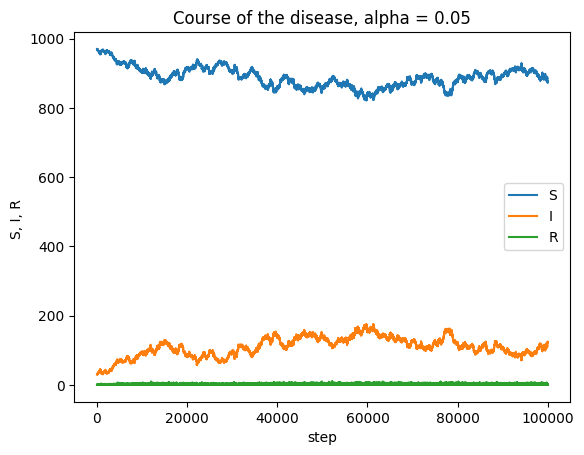

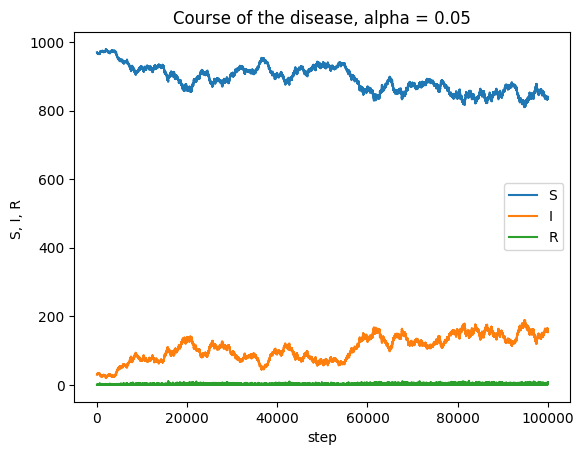

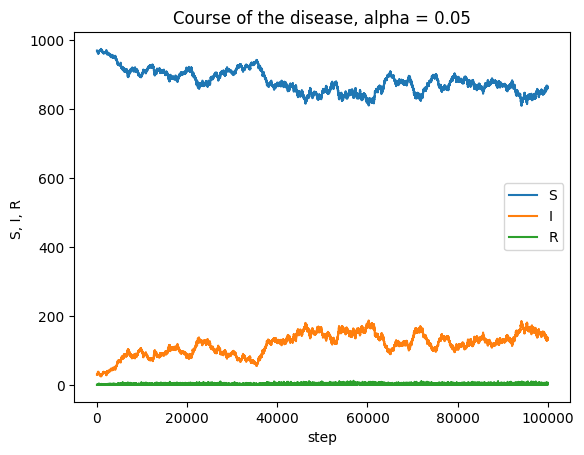

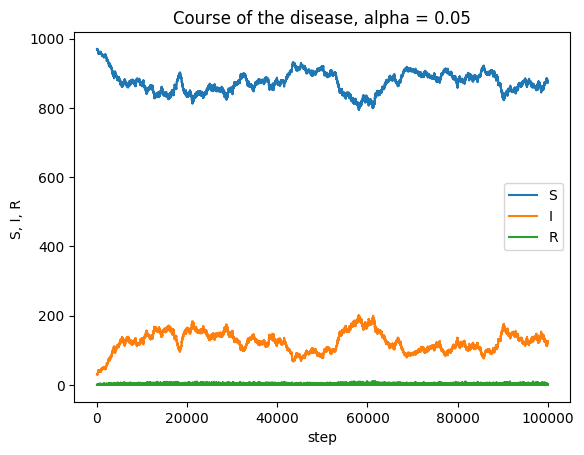

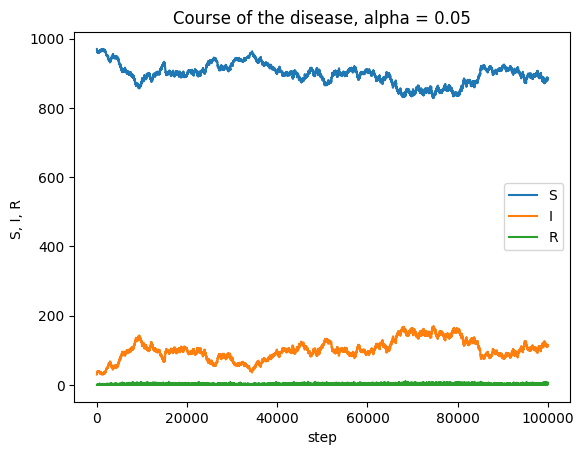

In [68]:
from matplotlib import pyplot as plt

for i in range(5):
    t = np.array(np.arange(len(S_plots[i])))
    S_agents = np.array(S_plots[i]) 
    I_agents = np.array(I_plots[i]) 
    R_agents = np.array(R_plots[i]) 


    plt.plot(t, S_agents, '-', label='S')
    plt.plot(t, I_agents, '-', label='I')
    plt.plot(t, R_agents, '-', label='R')

    plt.legend()
    plt.title('Course of the disease, alpha = 0.05')
    plt.xlabel('step')
    plt.ylabel('S, I, R ')
    plt.show()

#### **Q1** - Comment on your plots: withe the parameters as in **P1**, is the disease endemic or does it die out?

The disease looks endemic.

#### **P2** - Start with $I_0 = 10$ infected agents and $\alpha = 0.005$ this time. procced as in **P1**

In [65]:
N_part = 1000  # Total agent population.
d = 0.95  # Diffusion probability.
beta = 0.05  # Infection spreading probability.
gamma = 0.001  # Recovery probability.
alpha = 0.005
L = 200  # Side of the lattice.

I0 = 10  # Initial number of infected agents.

steps = 100000

S_plots = []
I_plots = []
R_plots = []

for run in range(5):
    # Initialize agents position.
    x = np.random.randint(L, size=N_part)
    y = np.random.randint(L, size=N_part)

    # Initialize agents status.
    status = np.zeros(N_part)
    status[0:I0] = 1


    S = []  # Keeps track of the susceptible agents.
    I = []  # Keeps track of the infectious agents.
    R = []  # Keeps track of the recovered agents.
    S.append(N_part - I0)
    I.append(I0)
    R.append(0)

    for step in range(steps):
        x, y, status = diffuse_spread_recover(x, y, status, d, beta, gamma, alpha, L)

        S.append(np.size(np.where(status == 0)[0]))
        I.append(np.size(np.where(status == 1)[0]))
        R.append(np.size(np.where(status == 2)[0]))
        if step % 5000 == 0:
            print("Hello step: ", step, " Run: ", run)

        if I[-1] == 0:
            break
    S_plots.append(S)
    I_plots.append(I)
    R_plots.append(R)

Hello step:  0  Run:  0
Hello step:  5000  Run:  0
Hello step:  10000  Run:  0
Hello step:  15000  Run:  0
Hello step:  20000  Run:  0
Hello step:  25000  Run:  0
Hello step:  30000  Run:  0
Hello step:  35000  Run:  0
Hello step:  40000  Run:  0
Hello step:  45000  Run:  0
Hello step:  50000  Run:  0
Hello step:  55000  Run:  0
Hello step:  60000  Run:  0
Hello step:  65000  Run:  0
Hello step:  70000  Run:  0
Hello step:  75000  Run:  0
Hello step:  80000  Run:  0
Hello step:  85000  Run:  0
Hello step:  90000  Run:  0
Hello step:  95000  Run:  0
Hello step:  0  Run:  1
Hello step:  5000  Run:  1
Hello step:  10000  Run:  1
Hello step:  15000  Run:  1
Hello step:  20000  Run:  1
Hello step:  25000  Run:  1
Hello step:  30000  Run:  1
Hello step:  35000  Run:  1
Hello step:  40000  Run:  1
Hello step:  45000  Run:  1
Hello step:  50000  Run:  1
Hello step:  55000  Run:  1
Hello step:  60000  Run:  1
Hello step:  65000  Run:  1
Hello step:  70000  Run:  1
Hello step:  75000  Run:  1
He

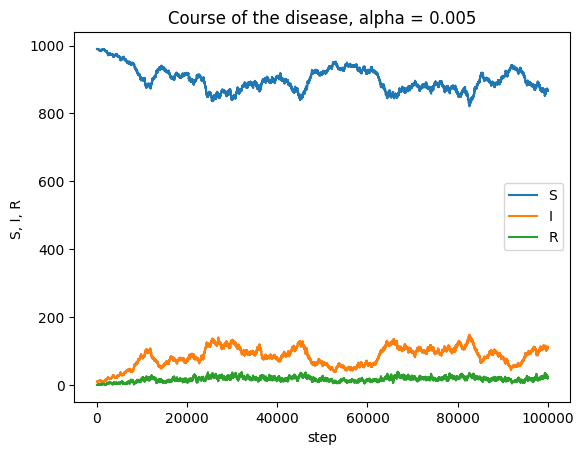

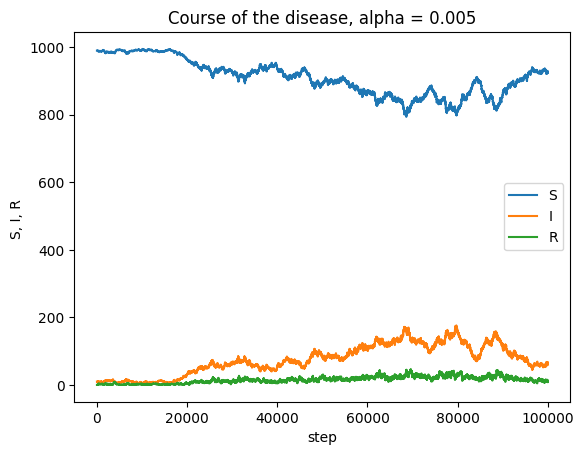

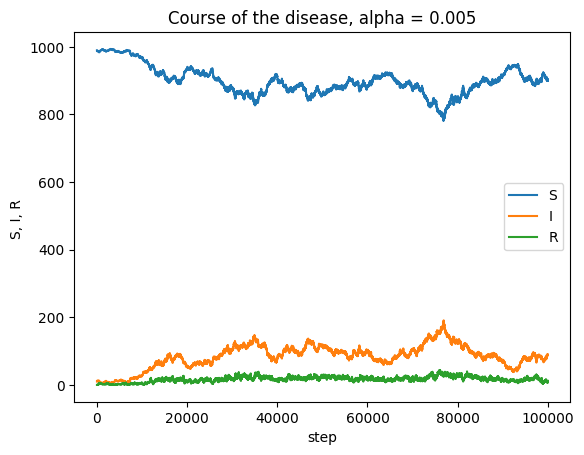

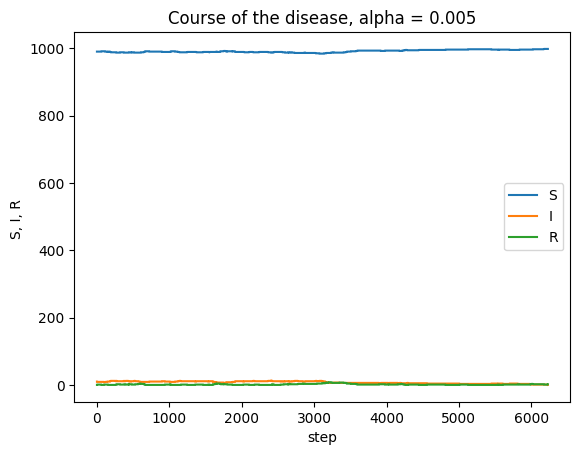

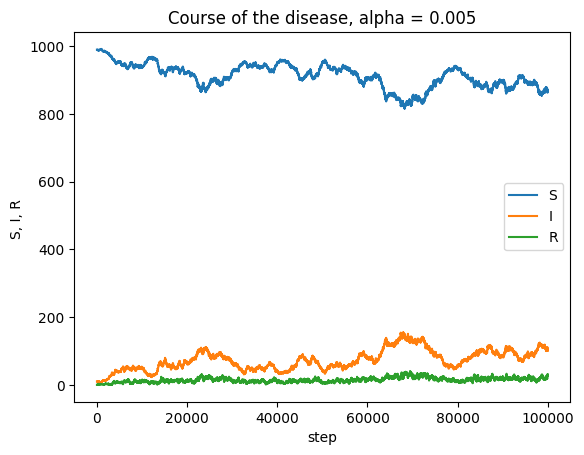

In [66]:
from matplotlib import pyplot as plt

for i in range(5):
    t = np.array(np.arange(len(S_plots[i])))
    S_agents = np.array(S_plots[i]) 
    I_agents = np.array(I_plots[i]) 
    R_agents = np.array(R_plots[i]) 


    plt.plot(t, S_agents, '-', label='S')
    plt.plot(t, I_agents, '-', label='I')
    plt.plot(t, R_agents, '-', label='R')

    plt.legend()
    plt.title('Course of the disease, alpha = 0.005')
    plt.xlabel('step')
    plt.ylabel('S, I, R ')
    plt.show()

#### **Q2** - Comment on your plots. How does it differ from **P1**

Seems the disease is more likely to die out due to the lower value of $\alpha$ and the smaller starting population of infected. Which is different from **P1** were the disease seems to be endemic.

The infected population is is in this setup generally closer to 0 than earlier.

#### **Exercise 4**

In [79]:
import numpy as np 
    
def nodes_degree(A):
    """
    Function returning the degree of a node.
    
    Parameters
    ==========
    A : Adjacency matrix (assumed symmetric).
    """
    
    degree = np.sum(A, axis=0)
    
    return degree

In [80]:
def path_length(A, i, j):
    """
    Function returning the minimum path length between thwo nodes.
    
    Parameters
    ==========
    A : Adjacency matrix (assumed symmetric).
    i, j : Nodes indices.
    """
    
    Lij = - 1
    
    if A[i, j] > 0:
        Lij = 1
    else:
        N = np.size(A[0, :])
        P = np.zeros([N, N]) + A
        n = 1
        running = True
        while running:
            P = np.matmul(P, A)
            n += 1
            running
            if P[i, j] > 0:
                Lij = n           
            if (n > N) or (Lij > 0):
                running = False   
    
    return Lij

In [81]:
def matrix_path_length(A):
    """
    Function returning a matrix L of minimum path length between nodes.
    
    Parameters
    ==========
    A : Adjacency matrix (assumed symmetric).
    """
    
    N = np.size(A[0, :])
    L = np.zeros([N, N]) - 1 
    
    for i in range(N):
        for j in range(i + 1, N):
            L[i, j] = path_length(A, i, j)
            L[j, i] = L[i, j]
    
    return L

In [82]:
def clustering_coefficient(A):
    """
    Function returning the clustering coefficient of a graph.
    
    Parameters
    ==========
    A : Adjacency matrix (assumed symmetric).
    """
            
    K = nodes_degree(A)
    N = np.size(K)

    C_n = np.sum(np.diagonal(np.linalg.matrix_power(A, 3)))
    C_d = np.sum(K * (K - 1))
    
    C = C_n / C_d
    
    return C

In [83]:
def erdos_renyi_rg(n, p):
    """
    Function generating an Erdős-Rényi random graph
    
    Parameters
    ==========
    n : Number of nodes.
    p : Probability that each possible edge is present.
    """
    
    A = np.zeros([n, n])    
    rn = np.random.rand(n, n)
    A[np.where(rn < p)] = 1
    
    for i in range(n):
        A[i, i] = 0
        
    # This below is for plotting in a circular arrangement.
    x = np.cos(np.arange(n) / n * 2 * np.pi)
    y = np.sin(np.arange(n) / n * 2 * np.pi) 
    
    return A, x, y

In [127]:
from matplotlib import pyplot as plt

n = 100
num_times = 10
p_list = np.array([0.02, 0.03, 0.04, 0.05,
                    0.06, 0.07, 0.08, 0.09,
                      0.1, 0.2, 0.4, 0.5,
                        0.6, 0.7, 0.8, 0.9,
                          1])


L_av = np.zeros((np.size(p_list), num_times))
C = np.zeros((np.size(p_list), num_times))




for i in range(np.size(p_list)):
    p = p_list[i]
    print(f'iteration {i}: p={p}')
    for run in range(num_times):
        print(f'Run {run}')
        A_ER, x_ER, y_ER = erdos_renyi_rg(n, p)
        C[i][run] = clustering_coefficient(A_ER)
        L = matrix_path_length(A_ER)
        for j in range(n):
            L_av[i][run] += np.sum(L[j,j+1:n])
        L_av[i][run] /= (n * (n-1) / 2)





iteration 0: p=0.02
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 1: p=0.03
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 2: p=0.04
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 3: p=0.05
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 4: p=0.06
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 5: p=0.07
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 6: p=0.08
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 7: p=0.09
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 8: p=0.1
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 9: p=0.2
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 10: p=0.4
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 11: p=0.5
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
iteration 12: p=0.6
Run 0
Run 1
Run 2
Run 

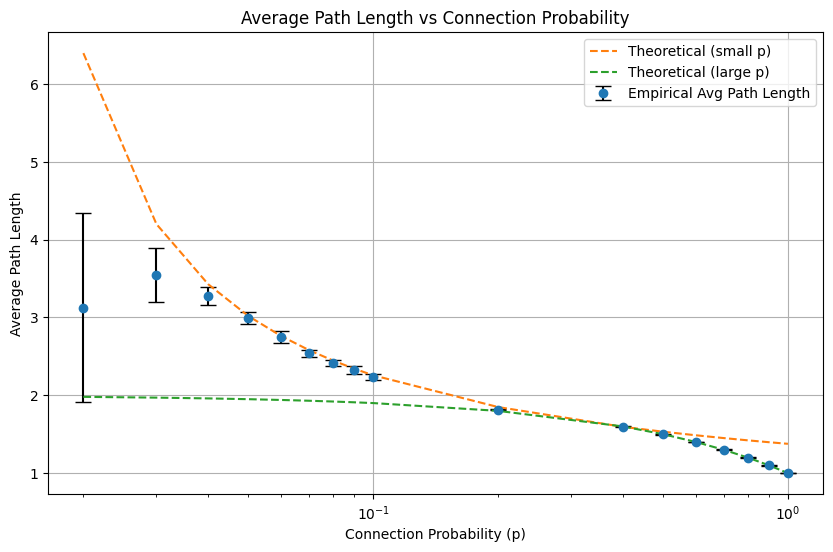

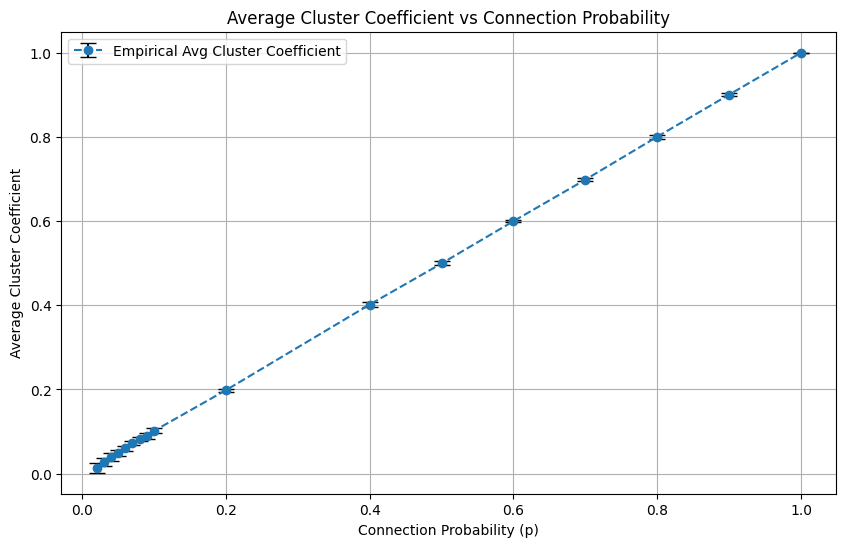

In [128]:
L_average = np.zeros(np.size(p_list))
L_errors = np.zeros(np.size(p_list))
C_average = np.zeros(np.size(p_list))
C_errors = np.zeros(np.size(p_list))
for i in range(np.size(p_list)):
    L_average[i] += np.mean(L_av[i])
    L_errors[i] += np.std(L_av[i])
    C_average[i] += np.mean(C[i])
    C_errors[i] += np.std(C[i])


# Theoretical predictions
gamma = 0.57722  # Euler-Mascheroni constant
L_theoretical_small_p = (np.log(n) - gamma) / np.log(p_list * (n - 1)) + 1 / 2
L_theoretical_large_p = 2 - p_list


# Plot average path length
plt.figure(figsize=(10, 6))
plt.errorbar(p_list, L_average, yerr=L_errors, fmt='o', label="Empirical Avg Path Length",
             ecolor = "black", capsize=6)
plt.plot(p_list, L_theoretical_small_p, label="Theoretical (small p)", linestyle='--')
plt.plot(p_list, L_theoretical_large_p, label="Theoretical (large p)", linestyle='--')
plt.xscale('log')  # Set x-axis to log scale

plt.xlabel("Connection Probability (p)")
plt.ylabel("Average Path Length")
plt.title("Average Path Length vs Connection Probability")
plt.legend()
plt.grid()
plt.show()

# Plot average clustering coefficient
plt.figure(figsize=(10, 6))
plt.errorbar(p_list, C_average, yerr=C_errors, linestyle="--", marker="o", label="Empirical Avg Cluster Coefficient",
             ecolor = "black", capsize=6)

plt.xlabel("Connection Probability (p)")
plt.ylabel("Average Cluster Coefficient")
plt.title("Average Cluster Coefficient vs Connection Probability")
plt.legend()
plt.grid()
plt.show()

#### **TASK 2**

In [ ]:
from matplotlib import pyplot as plt

n = 200
num_times = 5
p_list = np.array([0.02, 0.03, 0.04, 0.05,
                    0.06, 0.07, 0.08, 0.09,
                      0.1, 0.2, 0.4, 0.5,
                        0.6, 0.7, 0.8, 0.9,
                          1])


L_av = np.zeros((np.size(p_list), num_times))
C = np.zeros((np.size(p_list), num_times))


A_ER, x_ER, y_ER = erdos_renyi_rg(n, p)

for i in range(np.size(p_list)):
    p = p_list[i]
    print(f'iteration {i}: p={p}')
    for run in range(num_times):
        print(f'Run {run}')
        A_ER, x_ER, y_ER = erdos_renyi_rg(n, p)
        C[i][run] = clustering_coefficient(A_ER)
        L = matrix_path_length(A_ER)
        for j in range(n):
            L_av[i][run] += np.sum(L[j,j+1:n])
        L_av[i][run] /= (n * (n-1) / 2)




iteration 0: p=0.02
Run 0
Run 1
Run 2
iteration 1: p=0.03
Run 0
Run 1
Run 2
iteration 2: p=0.04
Run 0
Run 1
Run 2
iteration 3: p=0.05
Run 0
Run 1
Run 2
iteration 4: p=0.06
Run 0
Run 1
Run 2
iteration 5: p=0.07
Run 0
Run 1
Run 2
iteration 6: p=0.08
Run 0
Run 1
Run 2
iteration 7: p=0.09
Run 0
Run 1
Run 2
iteration 8: p=0.1
Run 0
Run 1
Run 2
iteration 9: p=0.2
Run 0
Run 1
Run 2
iteration 10: p=0.4
Run 0
Run 1
Run 2
iteration 11: p=0.5
Run 0
Run 1
Run 2
iteration 12: p=0.6
Run 0
Run 1
Run 2
iteration 13: p=0.7
Run 0
Run 1
Run 2
iteration 14: p=0.8
Run 0
Run 1
Run 2
iteration 15: p=0.9
Run 0
Run 1
Run 2
iteration 16: p=1.0
Run 0
Run 1
Run 2


### **P3** and **P4**

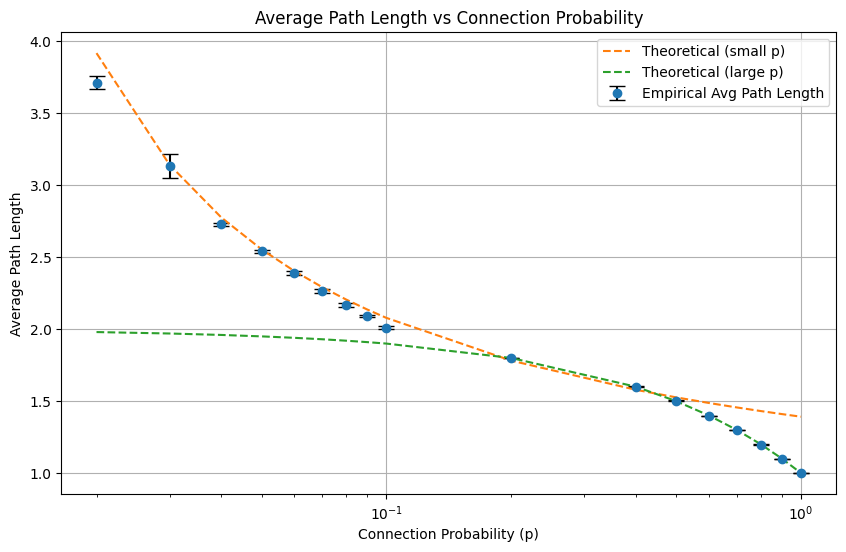

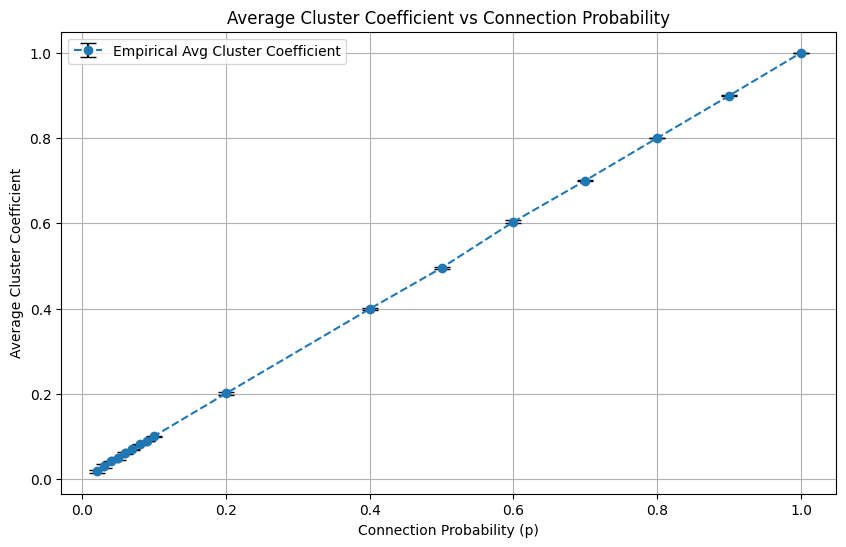

In [122]:
L_average = np.zeros(np.size(p_list))
L_errors = np.zeros(np.size(p_list))
C_average = np.zeros(np.size(p_list))
C_errors = np.zeros(np.size(p_list))
for i in range(np.size(p_list)):
    L_average[i] += np.mean(L_av[i])
    L_errors[i] += np.std(L_av[i])
    C_average[i] += np.mean(C[i])
    C_errors[i] += np.std(C[i])


# Theoretical predictions
gamma = 0.57722  # Euler-Mascheroni constant
L_theoretical_small_p = (np.log(n) - gamma) / np.log(p_list * (n - 1)) + 1 / 2
L_theoretical_large_p = 2 - p_list


# Plot average path length
plt.figure(figsize=(10, 6))
plt.errorbar(p_list, L_average, yerr=L_errors, fmt='o', label="Empirical Avg Path Length",
             ecolor = "black", capsize=6)
plt.plot(p_list, L_theoretical_small_p, label="Theoretical (small p)", linestyle='--')
plt.plot(p_list, L_theoretical_large_p, label="Theoretical (large p)", linestyle='--')
plt.xscale('log')  # Set x-axis to log scale

plt.xlabel("Connection Probability (p)")
plt.ylabel("Average Path Length")
plt.title("Average Path Length vs Connection Probability")
plt.legend()
plt.grid()
plt.show()



# Plot average clustering coefficient
plt.figure(figsize=(10, 6))
plt.errorbar(p_list, C_average, yerr=C_errors, linestyle="--", marker="o", label="Empirical Avg Cluster Coefficient",
             ecolor = "black", capsize=6)

plt.xlabel("Connection Probability (p)")
plt.ylabel("Average Cluster Coefficient")
plt.title("Average Cluster Coefficient vs Connection Probability")
plt.legend()
plt.grid()
plt.show()

#### **P3** Comment your graphs.
*Length plots:*
For small values of $p$ the plot with $n=100$ shows a significant difference between the theoretical value and simulated value as well as a much larger standard error. Otherwise they look similar, of course the values change as they depend on $n$ but they follow their theoretical values well.

*Cluster coefficient plots:*
Both plots look the same $C=p$. $C$ seems to be determined independent of $n$ at least for large $n$. 

### **Q1** - Why is the clustering coefficient for ER random graphs with parameter $p$ simply equal to $p$? Explain.


$$
C = \frac{\text{"Number of closed triples"}}{\text{"Number of all triples"}}
$$


There are ${n\choose 3}$ ways to pick nodes which can form a triangle and for each of them we have 3 triangles depending on which one is the starting node we also have the probability $p^3$ that they form a triangle (independent generation of edges). Hence, $$\text{"Number of closed triples"} = 3{n\choose 3}p^3$$

On the other hand the number of all connected triples is pretty much the same except we don't necessarily need 3 edges only 2 so we get $$\text{"Number of all triples"} = 3{n\choose 3}p^2$$

Therefore we get $$C = \frac{3{n\choose 3}p^3}{3{n\choose 3}p^2} = p$$